In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

# Data Story

### Data Source
Portion of full dataset that has been cleaned and manipulated to include location (in latitude/longitude and ecef-Regtangular Cartesian), street, time, distance to traffic sensor (in meters), and traffic count (at sensor closest to crash location)

In [4]:
crash_location = pd.read_pickle('crash_location.pkl')
crash_location.tail()

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,sensor_distance,traffic
141982,40.4541,-79.8908,KELLY ST,2016-10-07 01:02:00,"(853075.781582, -4784690.02494, 4116482.84218)",681.753346,37.0
141983,40.4578,-79.7397,OLD FRANKSTOWN RD,2016-12-07 11:59:00,"(865643.46358, -4782161.33507, 4116795.46809)",597.310206,311.0
141984,40.6674,-79.9790,VALENCIA RD,2016-12-06 05:14:00,"(843029.244793, -4770830.63491, 4134477.47916)",10.371036,75.0
141985,40.4430,-79.8390,PENN LINCOLN PY,2016-12-07 01:17:00,"(857542.248496, -4784703.93343, 4115544.86237)",117.253831,283.0
141986,40.4435,-80.0068,TENTH ST BY,2016-11-03 21:26:00,"(843519.558023, -4787159.39219, 4115587.117)",27.906064,163.0


If we visualize crash frequency over each hour, we see a peak around 17 corresponding to 5pm on a 12hr scale. It is not surprising the most crashes occur during rush hour because there is higher traffic and thus more opportunities for crashes.

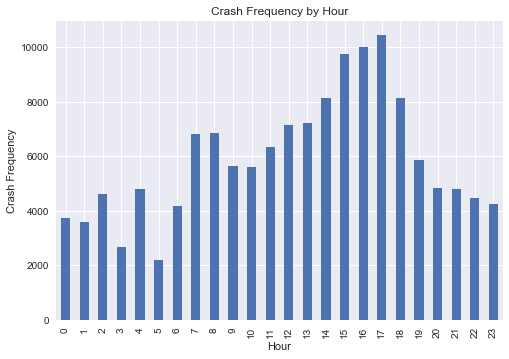

In [7]:
crash_location.datetime.dt.hour.value_counts().sort_index().plot(kind = 'bar')
plt.title('Crash Frequency by Hour')
plt.xlabel('Hour')
plt.ylabel('Crash Frequency')

In order to determine which hours have the highest risk of crashes, we can divide the total number of crashes each hour by the total hourly traffic to get crash frequency/1 vehicle of traffic or the risk for an individual car of experiencing a crash each hour.

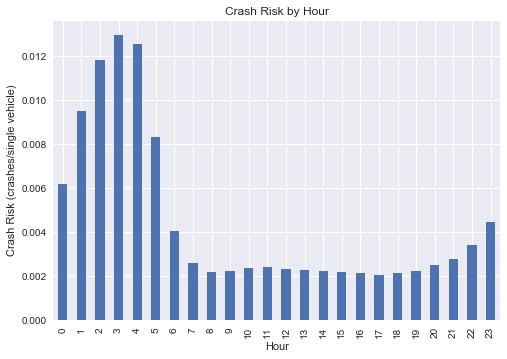

In [11]:
a = crash_location.datetime.dt.hour.value_counts().sort_index()
b = crash_location.groupby(crash_location.datetime.dt.hour).sum().traffic
(a/b).plot(kind = 'bar')
plt.title('Crash Risk by Hour')
plt.xlabel('Hour')
plt.ylabel('Crash Risk (crashes/single vehicle)')

Although the crash frequency is highest during the afternoon rush hour, crash risk spikes over night with 2-4am being the most risky hours.

Another way to study the relationship between crash risk/crash frequency and traffic is to use scatter plots

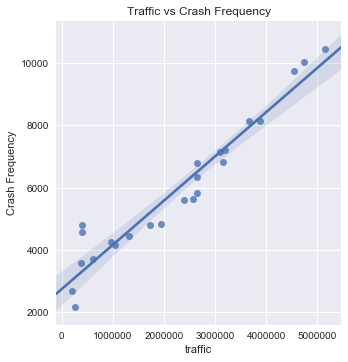

In [15]:
hourly_traffic_crashes = pd.concat([a,b], axis = 1)
sns.lmplot('traffic','datetime', data = hourly_traffic_crashes)
plt.title('Traffic vs Crash Frequency')
plt.ylabel('Crash Frequency')

The strong positive correlation between traffic and crash frequency supports the observation that high traffic periods correspond with higher crash frequencies.

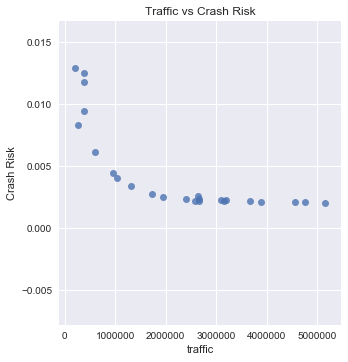

In [19]:
hourly_traffic_crashes['normalized'] = hourly_traffic_crashes.datetime/hourly_traffic_crashes.traffic
sns.lmplot('traffic','normalized', data = hourly_traffic_crashes, fit_reg = False)
plt.title('Traffic vs Crash Risk')
plt.ylabel('Crash Risk')

The relationship between crash risk and traffic reveals that low hourly traffic corresponds with a higher crash risk. It is important to realize that these low traffic periods occur during the night hours, so this plot serves to illustrate the relationship between low-traffic (night) hours and crash risk.

Let's look at the most dangerous roads in the Pittsburgh area.

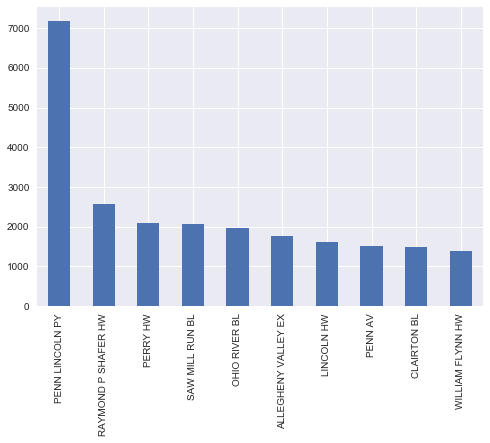

In [20]:
crash_location.STREET_NAME.value_counts().head(10).plot(kind = 'bar')

The highest crash frequency roads in the Pittsburgh area appear to all be highways! This is unsurprising given the relationship between traffic and crash frequency we have already demonstrated. If we look at crash risk for each road, how do our results change?

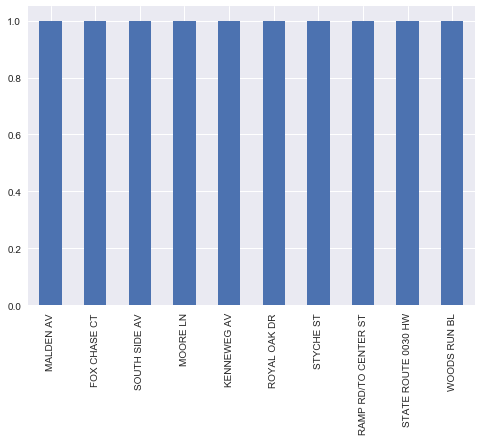

In [48]:
street_traffic = crash_location.groupby('STREET_NAME').sum().traffic
street_crashf = crash_location.STREET_NAME.value_counts().sort_index()
(street_crashf/street_traffic).sort_values(ascending = False).head(10).plot(kind = 'bar')

Wow! The top 10 "riskiest" roads have a risk factor of 1, or 1 crash/1 vehicle. That is unreasonably high so what happened here, let's some of these roads.

In [61]:
crash_location[(crash_location.STREET_NAME == 'MALDEN AV') | (crash_location.STREET_NAME == 'FOX CHASE CT') |
              (crash_location.STREET_NAME == 'SOUTH SIDE AV')]

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,sensor_distance,traffic
95501,40.3241,-80.120201,FOX CHASE CT,2013-04-03 17:27:00,"(835516.97071, -4797282.28676, 4105487.9388)",806.824070,1.0
137399,40.4695,-79.999300,SOUTH SIDE AV,2016-08-04 03:02:00,"(843820.858169, -4785204.02657, 4117783.92993)",525.218297,1.0
140461,40.4746,-80.033200,MALDEN AV,2016-08-01 02:30:00,"(840925.844082, -4785340.40993, 4118214.74465)",173.727799,1.0


These roads are ranked as riskiest because there is a single crash on the road and only one vehicle of traffic because these crashes occured at night and are in residential areas. In order to get a more useful ranking of crash risk, let's only consider roads that have a minimum traffic of 50 cars during at least one crash and more than one crash.

In [91]:
# In order to determine which roads to consider set new column for max traffic for any road, this must be greater than 50
maxt_di = crash_location.groupby(crash_location.STREET_NAME).max().traffic
maxt_di.to_dict()
crash_location['max_traffic'] = crash_location.STREET_NAME.map(maxt_di)
crash_location.tail()

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,sensor_distance,traffic,max_traffic
141982,40.4541,-79.8908,KELLY ST,2016-10-07 01:02:00,"(853075.781582, -4784690.02494, 4116482.84218)",681.753346,37.0,957.000000
141983,40.4578,-79.7397,OLD FRANKSTOWN RD,2016-12-07 11:59:00,"(865643.46358, -4782161.33507, 4116795.46809)",597.310206,311.0,880.000000
141984,40.6674,-79.9790,VALENCIA RD,2016-12-06 05:14:00,"(843029.244793, -4770830.63491, 4134477.47916)",10.371036,75.0,331.000000
141985,40.4430,-79.8390,PENN LINCOLN PY,2016-12-07 01:17:00,"(857542.248496, -4784703.93343, 4115544.86237)",117.253831,283.0,996.000000
141986,40.4435,-80.0068,TENTH ST BY,2016-11-03 21:26:00,"(843519.558023, -4787159.39219, 4115587.117)",27.906064,163.0,636.166667


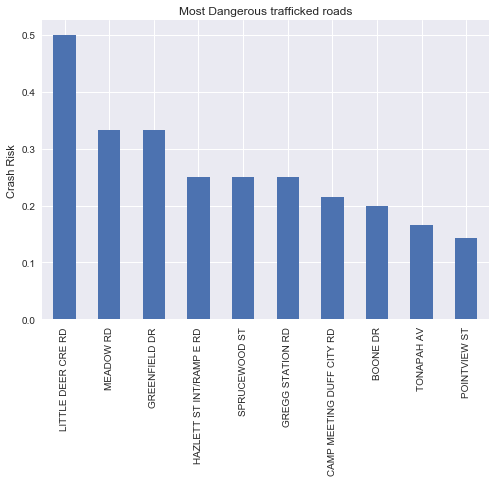

In [103]:
min_traffic = crash_location[(crash_location.max_traffic >= 50) & (crash_location.STREET_NAME.duplicated() == True)]
# duplicated() method returns boolean series indicating which streets are associated with multiple crashes
street_traffic = min_traffic.groupby('STREET_NAME').sum().traffic
street_crashf = min_traffic.STREET_NAME.value_counts().sort_index()
(street_crashf/street_traffic).sort_values(ascending = False).head(10).plot(kind = 'bar')
plt.title('Most Dangerous trafficked roads')
plt.ylabel('Crash Risk')

After restricting the considered roads, we find that Little Deer Cre[ek] road is the most risky road with .5 crashes/vehicle. It is obviously not reasonable that there is actually a crash for every 2 vehicles so let's investigate the limitations of the crash risk factor which measures crash occurences/traffic.

In [93]:
crash_location[(crash_location.STREET_NAME == 'LITTLE DEER CRE RD')]

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,sensor_distance,traffic,max_traffic
19176,40.583199,-79.826302,LITTLE DEER CRE RD,2006-06-06 22:30:00,"(856816.282801, -4774559.28357, 4127380.75979)",379.931888,117.0,117.0
22639,40.596600,-79.829597,LITTLE DEER CRE RD,2006-11-05 03:45:00,"(856370.660308, -4773655.53956, 4128510.82539)",931.862354,2.0,117.0


The extraordinarily high crash risk factor is clearly due to the crash at 3:45am where only two cars were on the road and thus the crash/vehicle was very high. In fact the other crash which occured when 117 vehicles were on the road only adds 1/117 or .009 to the crash risk factor.

The risk factor does a good job when there is a moderate amount of traffic but crashes at low traffic times have disproportionately high influence.

This can be rectified by modifying the contribution of a crash to the risk factor but the risk factor has other issues. Currently, we are considering only frequency of crashes but the true danger of a road is not only the frequency of its crashes but also the crashes severity. We will consider new data including severity, and take a look again at the most dangerous roads after finishing exploration of crash frequency.

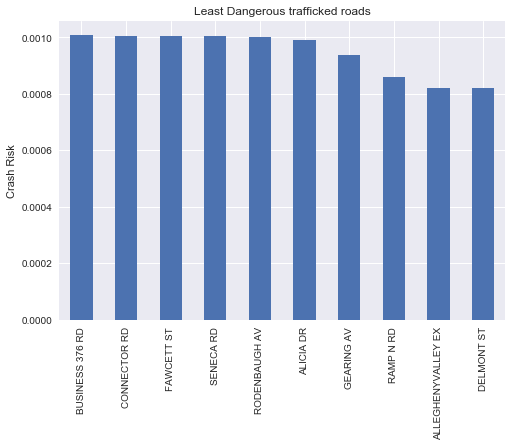

In [104]:
(street_crashf/street_traffic).sort_values(ascending = False).tail(10).plot(kind = 'bar')
plt.title('Least Dangerous trafficked roads')
plt.ylabel('Crash Risk')

The least dangerous roads have higher traffic, and few crashes. It is interesting that highways do not appear on the top 10 least dangerous given the high traffic counts.

In [101]:
crash_location[(crash_location.STREET_NAME == 'DELMONT ST')]

,DEC_LAT,DEC_LONG,STREET_NAME,datetime,ecef,sensor_distance,traffic,max_traffic
73194,40.420898,-80.004898,DELMONT ST,2011-05-05 15:40:00,"(843960.975188, -4788734.37367, 4113676.76534)",475.906836,203.5,1218.0
74964,40.416698,-80.003899,DELMONT ST,2011-07-04 16:40:00,"(844096.996576, -4789017.44559, 4113321.70051)",506.319558,1218.0,1218.0


How is crash risk factor distributed across all roads, let's use a histogram to visualize the entire road network (restricted to roads with 50+ vehicle max traffic and more than a single crash)

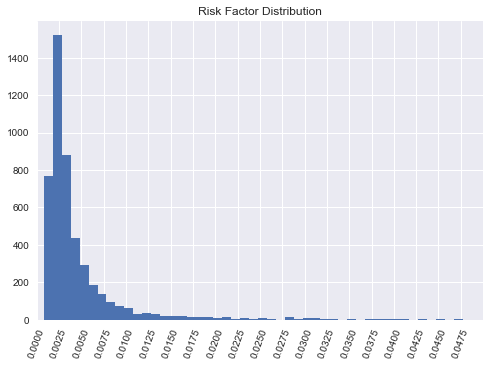

In [118]:
(street_crashf/street_traffic).hist(bins = 500)
plt.xlim([0, .05])
plt.xticks(np.arange(0, .05, .0025));
plt.xticks(rotation = 70)
plt.title('Risk Factor Distribution')

The risk factor distribution reveals a right skew, that we have identified as being the result of accidents at very low traffic periods. We will revisit this distribution after we have accounted for severity.

How does datetime data affect crash frequency?

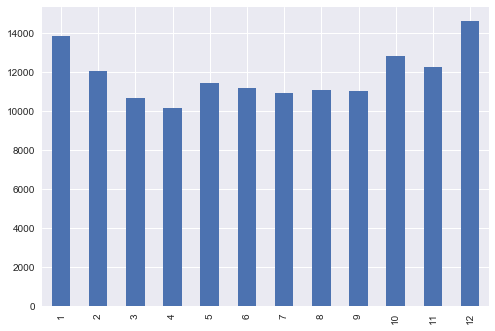

In [129]:
crash_location.datetime.dt.month.value_counts().sort_index().plot(kind = 'bar')

It appears crash frequency is higher in the winter months but it is difficult to make any conclusions. A limitation of the data is the traffic counts come from hourly averages between 2012 and 2014. This means that the influence of changes in traffic cannot be removed from the data.

For a clearer example let's look at year to year changes in crash frequency.

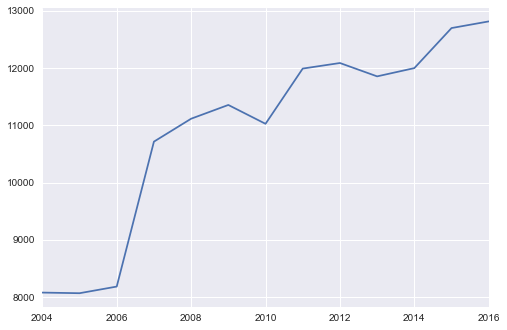

In [119]:
crash_location.datetime.dt.year.value_counts().sort_index().plot()

Looking at this graph, it is tempting to conclude that the roads are getting more dangerous year to year. However, it is very likely that total traffic is also increasing year to year.

Because crash frequency is highly dependent on traffic, any conclusions that crash risk (crashes/vehicle) require traffic data specific to the factor that is being examined. In the case of hourly crashes, hourly traffic data exists to study risk, but in this and most other cases no conclusions regarding risk can be made.